In [1]:
# Setup code for this notebook
import random 
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic gto make matplotlib figures appear inline
# in the notebook rather than in a new window
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Write function to load the cifar-10 data
# The original code is from http://cs231n.github.io/assignment1/
# The function is in data_utils.py file for reusing.
import cPickle as pickle
import numpy as np
import os

def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = pickle.load(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    # load all of cifar
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)    
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

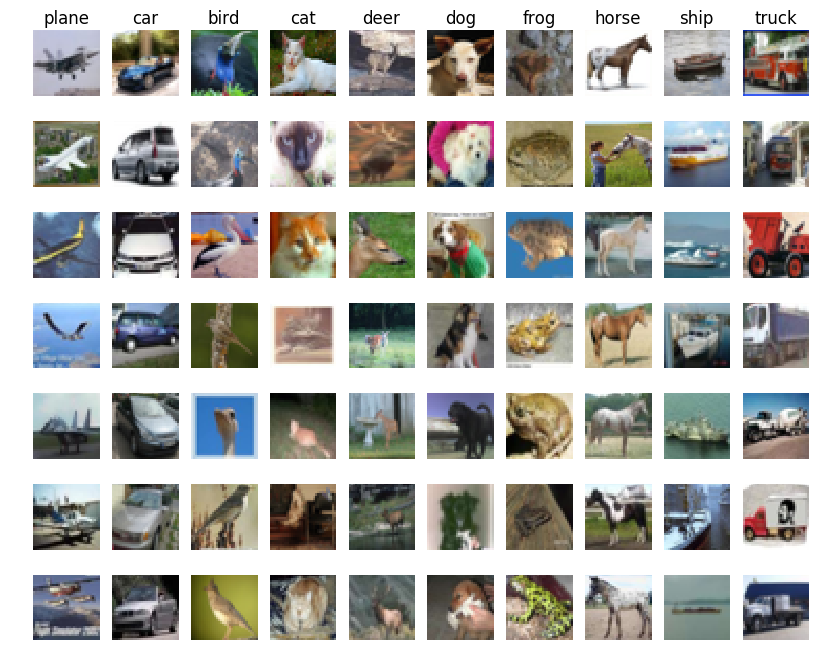

Train data shape:  (3073L, 49000L)
Train labels shape:  (49000L,)
Validation data shape:  (3073L, 1000L)
Validation labels shape:  (1000L,)
Test data shape:  (3073L, 10000L)
Test labels shape:  (10000L,)


In [3]:
#from algorithms.data_utils import load_CIFAR10
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def get_CIFAR10_data(num_training=49000, num_val=1000, num_test=10000, show_sample=True):
    """
    Load the CIFAR-10 dataset, and divide the sample into training set, validation set and test set
    """

    cifar10_dir = 'datasets\CIFAR10'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # subsample the data for validation set
    mask = xrange(num_training, num_training + num_val)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = xrange(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = xrange(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    return X_train, y_train, X_val, y_val, X_test, y_test

def visualize_sample(X_train, y_train, classes, samples_per_class=7):
    """visualize some samples in the training datasets """
    num_classes = len(classes)
    for y, cls in enumerate(classes):
        idxs = np.flatnonzero(y_train == y) # get all the indexes of cls
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs): # plot the image one by one
            plt_idx = i * num_classes + y + 1 # i*num_classes and y+1 determine the row and column respectively
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(X_train[idx].astype('uint8'))
            plt.axis('off')
            if i == 0:
                plt.title(cls)
    plt.show()
    
def preprocessing_CIFAR10_data(X_train, y_train, X_val, y_val, X_test, y_test):
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1)) # [49000, 3072]
    X_val = np.reshape(X_val, (X_val.shape[0], -1)) # [1000, 3072]
    X_test = np.reshape(X_test, (X_test.shape[0], -1)) # [10000, 3072]
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    
    # Add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]).T
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))]).T
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]).T
    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above functions to get our data
X_train_raw, y_train_raw, X_val_raw, y_val_raw, X_test_raw, y_test_raw = get_CIFAR10_data()
visualize_sample(X_train_raw, y_train_raw, classes)

X_train, y_train, X_val, y_val, X_test, y_test = preprocessing_CIFAR10_data(X_train_raw, y_train_raw, X_val_raw, y_val_raw, X_test_raw, y_test_raw)

# As a sanity check, we print out th size of the training and test data dimenstion
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

In [5]:
def loss_grad_logistic_naive(W, X, y, reg):
    """
    Compute the loss and gradients using logistic function 
    with loop, which is slow.
    Parameters
    ----------
    W: (1, D) array of weights, D is the dimension of one sample.
    X: (D, N) array of training data, each column is a training sample with D-dimension.
    y: (N, ) 1-dimension array of target data with length N.
    reg: (float) regularization strength for optimization.
    Returns
    -------
    a tuple of two items (loss, grad)
    loss: (float)
    grad: (array) with respect to self.W
    """
    dim, num_train = X.shape
    loss = 0
    grad = np.zeros_like(W) # [1, D]
    for i in xrange(num_train):
        sample_x = X[:, i]
        f_x = 0
        for idx in xrange(sample_x.shape[0]):
            f_x += W[0, idx] * sample_x[idx]
        h_x = 1.0 / (1 + np.exp(-f_x))
        loss += y[i] * np.log(h_x) + (1 - y[i]) * np.log(1 - h_x)

        grad += (h_x - y[i]) * sample_x # [D, ]
    loss /= -num_train
    loss += 0.5 * reg * np.sum(W * W) # add regularization

    grad /= num_train
    grad += reg * W # add regularization
    return loss, grad

def loss_grad_logistic_vectorized(W, X, y, reg):
    """Compute the loss and gradients with weights, vectorized version"""
    dim, num_train = X.shape
    loss = 0
    grad = np.zeros_like(W) # [1, D]
    # print W
    f_x_mat = W.dot(X) # [1, D] * [D, N]
    h_x_mat = 1.0 / (1.0 + np.exp(-f_x_mat)) # [1, N]
    loss = np.sum(y * np.log(h_x_mat) + (1 - y) * np.log(1 - h_x_mat))
    loss = -1.0 / num_train * loss + 0.5 * reg * np.sum(W * W)
    grad = (h_x_mat - y).dot(X.T) # [1, D]
    grad = 1.0 / num_train * grad + reg * W
    
    return loss, grad

In [6]:
# Set the label of the first class to be one, and 0 for others
from copy import deepcopy
y_train_test_loss = deepcopy(y_train)
idxs_zero = y_train_test_loss == 0
y_train_test_loss[idxs_zero] = 1
y_train_test_loss[-idxs_zero] = 0

# Test the loss and gradient and compare between two implementations
#from algorithms.classifiers import loss_grad_logistic_naive, loss_grad_logistic_vectorized
import time

# generate a rand weights W 
W = np.random.randn(1, X_train.shape[0]) * 0.001
tic = time.time()
loss_naive, grad_naive = loss_grad_logistic_naive(W, X_train, y_train_test_loss, 0)
toc = time.time()
print 'Naive loss: %f, and gradient: computed in %fs' % (loss_naive, toc - tic)

tic = time.time()
loss_vec, grad_vect = loss_grad_logistic_vectorized(W, X_train, y_train_test_loss, 0)
toc = time.time()
print 'Vectorized loss: %f, and gradient: computed in %fs' % (loss_vec, toc - tic)

# Compare the gradient, because the gradient is a vector, we canuse the Frobenius norm to compare them
# the Frobenius norm of two matrices is the square root of the squared sum of differences of all elements
diff = np.linalg.norm(grad_naive - grad_vect, ord='fro')
# Randomly choose some gradient to check
idxs = np.random.choice(X_train.shape[0], 10, replace=False)
print idxs
print grad_naive[0, idxs]
print grad_vect[0, idxs]
print 'Gradient difference between naive and vectorized version is: %f' % diff
del loss_naive, loss_vec, grad_naive, y_train_test_loss

C:\Users\Prafulla\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.


Naive loss: 1.330896, and gradient: computed in 80.496000s
Vectorized loss: 1.330896, and gradient: computed in 0.125000s
[1683 1888 1815  698 1866 2263 2938  410 1889  665]
[ 0.69512882  3.52976684  3.5084452   1.13087493  1.80153809  3.84841864
  6.00996913  4.62213738  1.76515475  6.63745085]
[ 0.69512882  3.52976684  3.5084452   1.13087493  1.80153809  3.84841864
  6.00996913  4.62213738  1.76515475  6.63745085]
Gradient difference between naive and vectorized version is: 0.000000


In [9]:
# file: algorithms/gradient_check.py
from random import randrange
def grad_check_sparse(f, x, analytic_grad, num_checks):
  """
  sample a few random elements and only return numerical
  in this dimensions.
  """
  h = 1e-5

  print x.shape

  for i in xrange(num_checks):
    ix = tuple([randrange(m) for m in x.shape])
    print ix
    x[ix] += h # increment by h
    fxph = f(x) # evaluate f(x + h)
    x[ix] -= 2 * h # increment by h
    fxmh = f(x) # evaluate f(x - h)
    x[ix] += h # reset

    grad_numerical = (fxph - fxmh) / (2 * h)
    grad_analytic = analytic_grad[ix]
    rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
    print 'numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error)
    
# Check gradient using numerical gradient along several randomly chosen dimenstion
#from algorithms.gradient_check import grad_check_sparse
f = lambda w: loss_grad_logistic_vectorized(w, X_train, y_train, 0)[0]
grad_numerical = grad_check_sparse(f, W, grad_vect, 10)

(1L, 3073L)
(0, 2704)
numerical: 20.465828 analytic: 4.721422, relative error: 6.250943e-01
(0, 2279)
numerical: 22.979904 analytic: 1.407123, relative error: 8.846007e-01
(0, 2181)
numerical: 12.755948 analytic: 4.291173, relative error: 4.965516e-01
(0, 1686)
numerical: -5.577491 analytic: 1.214760, relative error: 1.000000e+00
(0, 576)
numerical: 4.572384 analytic: 10.289284, relative error: 3.846742e-01
(0, 1462)
numerical: 11.771870 analytic: 2.600958, relative error: 6.380729e-01
(0, 2111)
numerical: 21.496380 analytic: 3.069182, relative error: 7.501232e-01
(0, 1682)
numerical: 0.588911 analytic: -2.302989, relative error: 1.000000e+00
(0, 399)
numerical: 0.695824 analytic: 8.234032, relative error: 8.441578e-01
(0, 2664)
numerical: 20.428462 analytic: 4.617001, relative error: 6.313104e-01


In [12]:
class LinearClassifier:

    def __init__(self):
        self.W = None # set up the weight matrix 

    def train(self, X, y, method='sgd', batch_size=200, learning_rate=1e-4,
              reg = 1e3, num_iters=1000, verbose=False, vectorized=True):
        """
        Train linear classifer using batch gradient descent or stochastic gradient descent
        Parameters
        ----------
        X: (D x N) array of training data, each column is a training sample with D-dimension.
        y: (N, ) 1-dimension array of target data with length N.
        method: (string) determine whether using 'bgd' or 'sgd'.
        batch_size: (integer) number of training examples to use at each step.
        learning_rate: (float) learning rate for optimization.
        reg: (float) regularization strength for optimization.
        num_iters: (integer) number of steps to take when optimization.
        verbose: (boolean) if True, print out the progress (loss) when optimization.
        Returns
        -------
        losses_history: (list) of losses at each training iteration
        """

        dim, num_train = X.shape
        num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes

        if self.W is None:
            # initialize the weights with small values
            if num_classes == 2: # just need weights for one class
                self.W = np.random.randn(1, dim) * 0.001
            else: # weigths for each class
                self.W = np.random.randn(num_classes, dim) * 0.001

        losses_history = []

        for i in xrange(num_iters):
            if method == 'bgd':
                loss, grad = self.loss_grad(X, y, reg, vectorized)
            else:
                # randomly choose a min-batch of samples
                idxs = np.random.choice(num_train, batch_size, replace=False)
                loss, grad = self.loss_grad(X[:, idxs], y[idxs], reg, vectorized) # grad => [K x D]
            losses_history.append(loss)

            # update weights
            self.W -= learning_rate * grad # [K x D]
            # print self.W
            # print 'dsfad', grad.shape
            if verbose and (i % 100 == 0):
                print 'iteration %d/%d: loss %f' % (i, num_iters, loss)

        return losses_history

    def predict(self, X):
        """
        Predict value of y using trained weights
        Parameters
        ----------
        X: (D x N) array of data, each column is a sample with D-dimension.
        Returns
        -------
        pred_ys: (N, ) 1-dimension array of y for N sampels
        h_x_mat: Normalized scores
        """
        pred_ys = np.zeros(X.shape[1])
        f_x_mat = self.W.dot(X)
        if self.__class__.__name__ == 'Logistic':
            pred_ys = f_x_mat.squeeze() >=0
        else: # multiclassification
            pred_ys = np.argmax(f_x_mat, axis=0)
        # normalized score
        h_x_mat = 1.0 / (1.0 + np.exp(-f_x_mat)) # [1, N]
        h_x_mat = h_x_mat.squeeze()
        return pred_ys, h_x_mat

    def loss_grad(self, X, y, reg, vectorized=True):
        """
        Compute the loss and gradients.
        Parameters
        ----------
        The same as self.train()
        Returns
        -------
        a tuple of two items (loss, grad)
        loss: (float)
        grad: (array) with respect to self.W
        """
        pass


In [14]:
# Subclasses of linear classifier
class Logistic(LinearClassifier):
    """A subclass for binary classification using logistic function"""
    def loss_grad(self, X, y, reg, vectorized=True):
        if vectorized:
            return loss_grad_logistic_vectorized(self.W, X, y, reg)
        else:
            return loss_grad_logistic_naive(self.W, X, y, reg)

In [15]:
logistic_classifiers = []
num_classes = np.max(y_train) + 1
losses = []
for i in xrange(num_classes):
    print '\nThe %d/%dth logistic classifier training...' % (i+1, num_classes)
    y_train_logistic = deepcopy(y_train)
    idxs_i = y_train_logistic == i
    y_train_logistic[idxs_i] = 1
    y_train_logistic[-idxs_i] = 0
    logistic = Logistic()
    loss = logistic.train(X_train, y_train_logistic, method='sgd', batch_size=200, learning_rate=1e-6,
              reg = 1e3, num_iters=1000, verbose=True, vectorized=True)
    losses.append(loss)
    logistic_classifiers.append(logistic)



The 1/10th logistic classifier training...
iteration 0/1000: loss 2.944912


C:\Users\Prafulla\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.


iteration 100/1000: loss 1.924243
iteration 200/1000: loss 1.732708
iteration 300/1000: loss 1.465950
iteration 400/1000: loss 1.291391
iteration 500/1000: loss 1.235606
iteration 600/1000: loss 1.047684
iteration 700/1000: loss 1.028225
iteration 800/1000: loss 0.912857
iteration 900/1000: loss 0.883539

The 2/10th logistic classifier training...
iteration 0/1000: loss 2.624233
iteration 100/1000: loss 2.001591
iteration 200/1000: loss 1.721731
iteration 300/1000: loss 1.486241
iteration 400/1000: loss 1.358698
iteration 500/1000: loss 1.165647
iteration 600/1000: loss 1.105461
iteration 700/1000: loss 1.005045
iteration 800/1000: loss 0.951600
iteration 900/1000: loss 0.892224

The 3/10th logistic classifier training...
iteration 0/1000: loss 3.127103
iteration 100/1000: loss 2.002074
iteration 200/1000: loss 1.751341
iteration 300/1000: loss 1.562828
iteration 400/1000: loss 1.362259
iteration 500/1000: loss 1.233678
iteration 600/1000: loss 1.112915
iteration 700/1000: loss 1.02733

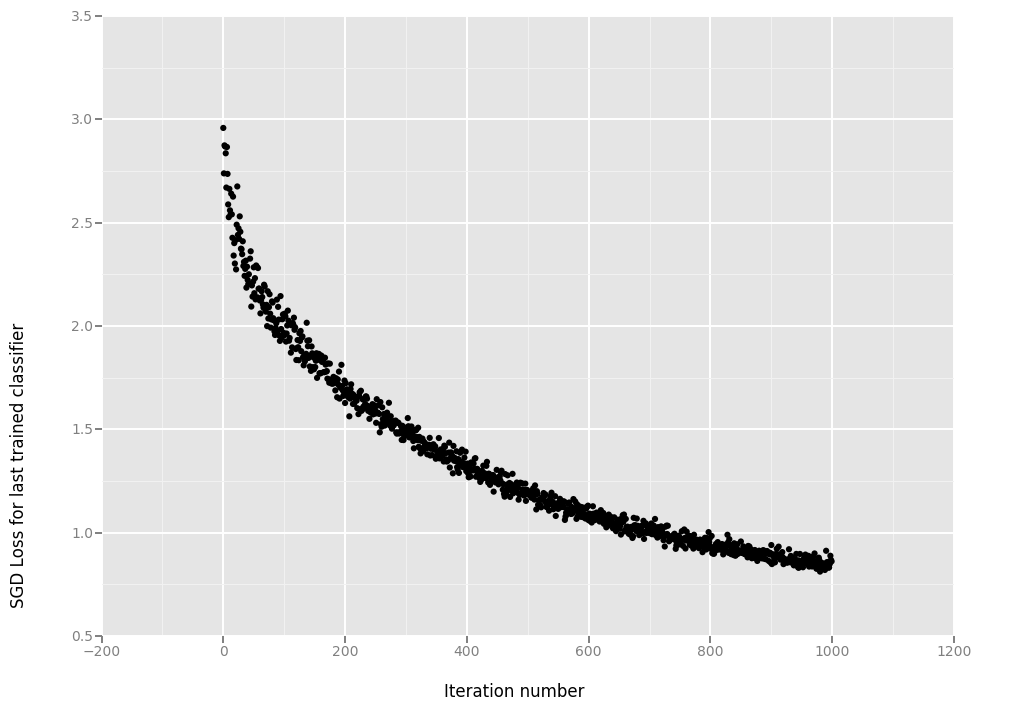

<ggplot: (23595412)>

In [17]:
from ggplot import *
# plot the loss of the last trained logistic classifier
qplot(xrange(len(losses[9])), losses[9]) + labs(x='Iteration number', y='SGD Loss for last trained classifier')


In [18]:
# Compute the accuracy of training data and validation data
def predict_one_vs_all(logistic_classifiers, X, num_classes):
    scores = np.zeros((num_classes, X.shape[1]))
    for i in xrange(num_classes):
        logistic = logistic_classifiers[i]
        scores[i, :] = logistic.predict(X)[1]
    pred_X = np.argmax(scores, axis=0)
    return pred_X

pred_train_one_vs_all = predict_one_vs_all(logistic_classifiers, X_train, num_classes)
pred_val_one_vs_all = predict_one_vs_all(logistic_classifiers, X_val, num_classes)
pred_test_one_vs_all = predict_one_vs_all(logistic_classifiers, X_test, num_classes)
print 'Training dataset accuracy: %f' % (np.mean(y_train == pred_train_one_vs_all))
print 'Validation dataset accuracy: %f' % (np.mean(y_val == pred_val_one_vs_all))
print 'Test datast accuracy: %f' % (np.mean(y_test == pred_test_one_vs_all))

Training dataset accuracy: 0.349163
Validation dataset accuracy: 0.371000
Test datast accuracy: 0.330500
